# Gyroscope DDPG reward function testing (spinup library)

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control
from custom_functions.custom_functions import read_progress

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Gyro data

In [104]:
def read_data(filepath):
    
    # count lines
    file = open(filepath, "r")
    count = len(file.readlines())
    data = np.empty([count, 16])
    file.seek(0)
    
    # read each line as a numpy array
    row = 0
    for x in file:
        data[row] = np.array(x.split('\t')).astype(np.float)
        row += 1
    file.close()
    
    # change time from usec into sec and shift the beginning to 0
    data[:,11] = data[:,11] / 1e6
    data[:,11] -= data[0,11]
    
    return data

def angle_normalize(x, lim = np.pi):
    return ((x + lim) % (2 * lim)) - lim 

def plot_data(data):
    
    f, axs = plt.subplots(2,2,figsize=(14,7))

    plt.subplot(2,2,1)
    plt.title('Red gimbal angle',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\theta$ [deg]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,14])
    plt.plot(data[:,11], angle_normalize(data[:,2],180))

    plt.subplot(2,2,2)
    plt.title('Blue gimbal angle',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\theta$ [deg]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,15])
    plt.plot(data[:,11], angle_normalize(data[:,4],180))
    
    plt.subplot(2,2,3)
    plt.title('Red gimbal velocity',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\dot(\theta)$ [rpm]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,3])

    plt.subplot(2,2,4)
    plt.title('Blue gimbal velocity',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\dot(\theta)$ [rpm]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,5])
    
def plot_report(data_list, legend_list=None, limit=None):
    
    f, axs = plt.subplots(2,1,figsize=(14,10))
    plt.subplots_adjust(hspace=0.3)
    
    data = data_list[0]
    
    plt.subplot(2,1,1)
    plt.title('Step response of red gimbal',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel('position [deg]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11]-30, data[:,14], 'r--')
    
    plt.subplot(2,1,2)
    plt.title('Step response of blue gimbal',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel('position [deg]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11]-30, data[:,15], 'r--')

    for data in data_list:
        
        data[:,11] -= 30
        
        plt.subplot(2,1,1)
        plt.plot(data[:,11], angle_normalize(data[:,2],180))
        
        plt.subplot(2,1,2)
        plt.plot(data[:,11], angle_normalize(data[:,4],180))
        
    plt.subplot(2,1,1)
    plt.xlim([0,150])
    if limit:
        plt.ylim([limit[0],limit[1]])
    if legend_list:
        plt.legend(legend_list,fontsize=16)
        
    plt.subplot(2,1,2)
    plt.xlim([0,150])
    if limit:
        plt.ylim([limit[2],limit[3]])
    if legend_list:
        plt.legend(legend_list,fontsize=16)

# Test T = 0.05 and T = 0.02 for FL and RL trained with T = 0.05s

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

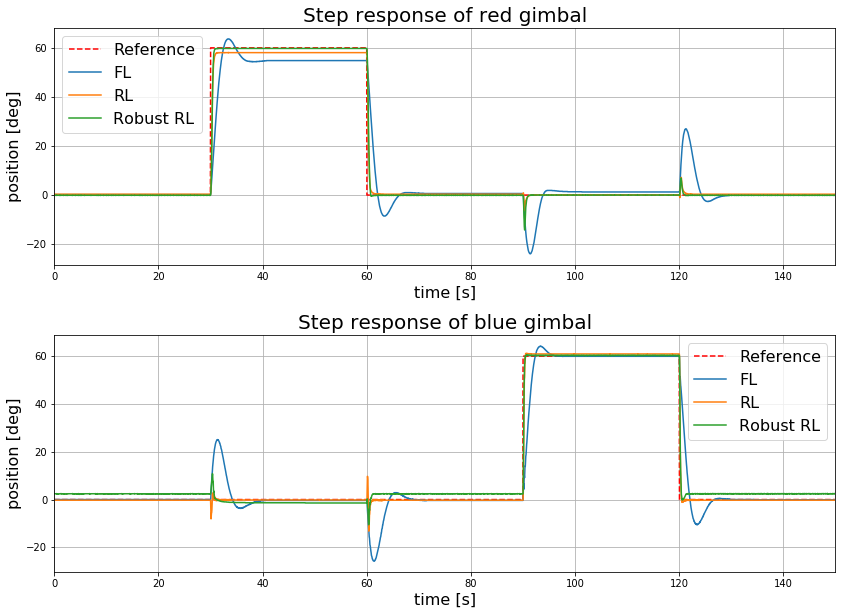

In [73]:
plot_report([read_data('FL002.txt'), read_data('NR002.txt'), read_data('R002.txt')],['Reference','FL','RL','Robust RL'])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

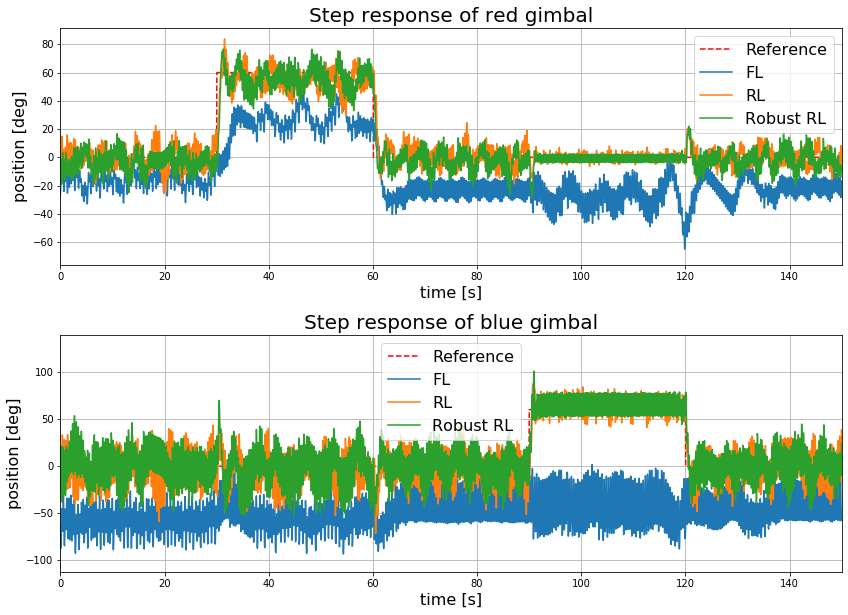

In [74]:
plot_report([read_data('FL005.txt'), read_data('NR005.txt'), read_data('R005.txt')],['Reference','FL','RL','Robust RL'])

# Test RL trained on gyro with T = 0.05s

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

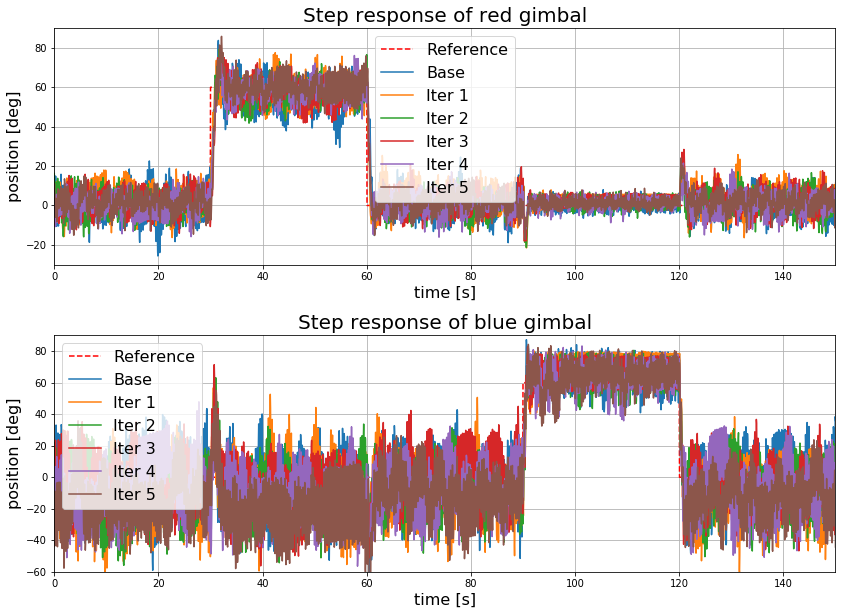

In [105]:
plot_report([read_data('NR005.txt'), read_data('NR005_m1.txt'), read_data('NR005_m2.txt'), 
            read_data('NR005_m3.txt'), read_data('NR005_m4.txt'), read_data('NR005_m5.txt')],
            ['Reference','Base','Iter 1','Iter 2','Iter 3','Iter 4','Iter 5'],[-30,90,-60,90])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

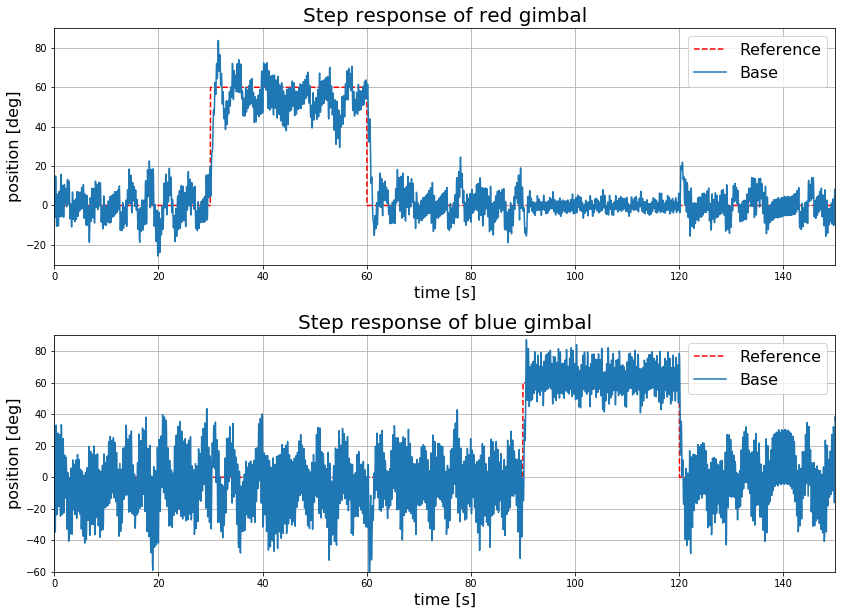

In [106]:
plot_report([read_data('NR005.txt')], ['Reference','Base'],[-30,90,-60,90])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

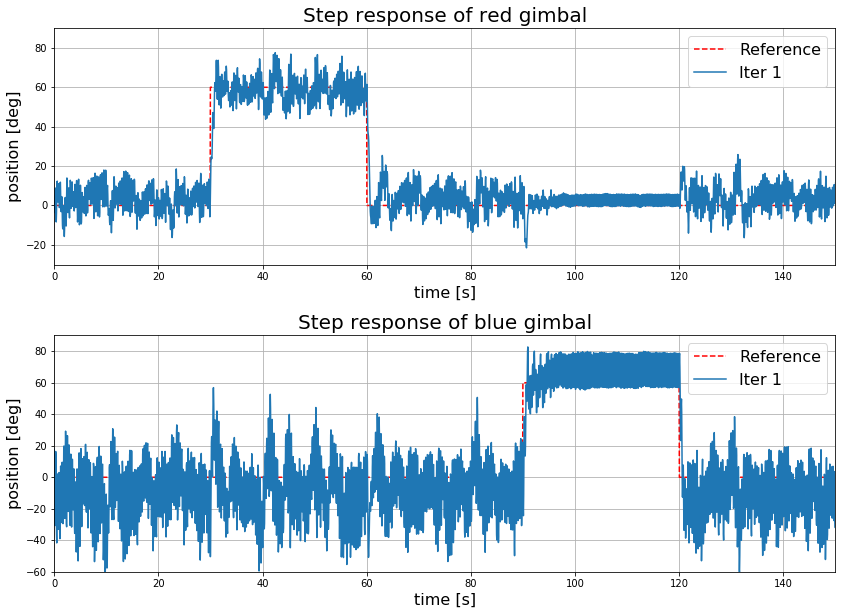

In [107]:
plot_report([read_data('NR005_m1.txt')],['Reference','Iter 1'],[-30,90,-60,90])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

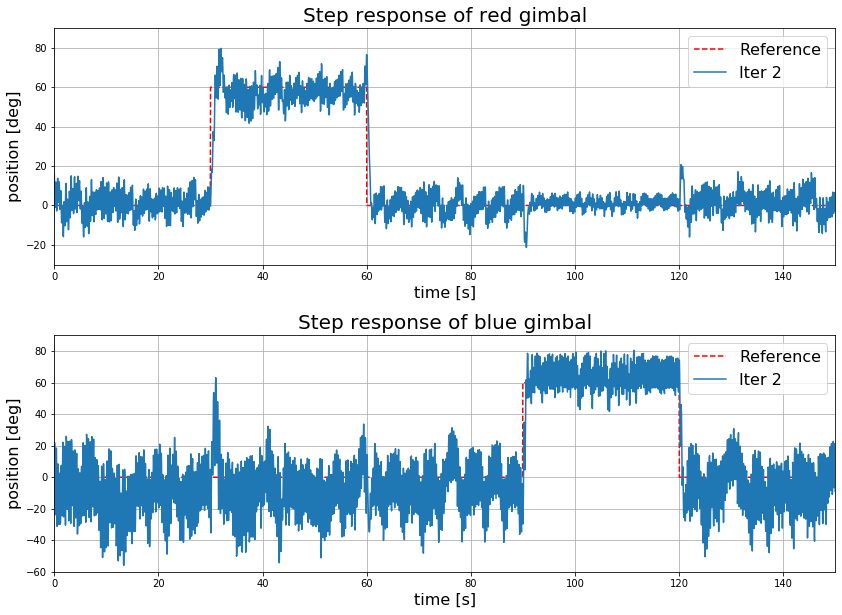

In [108]:
plot_report([read_data('NR005_m2.txt')],['Reference','Iter 2'],[-30,90,-60,90])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

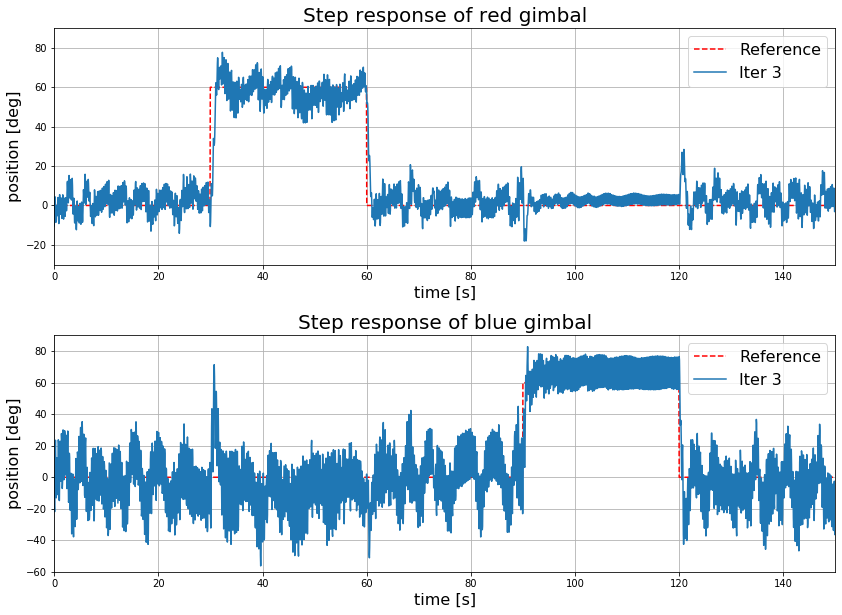

In [109]:
plot_report([read_data('NR005_m3.txt')],['Reference','Iter 3'],[-30,90,-60,90])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

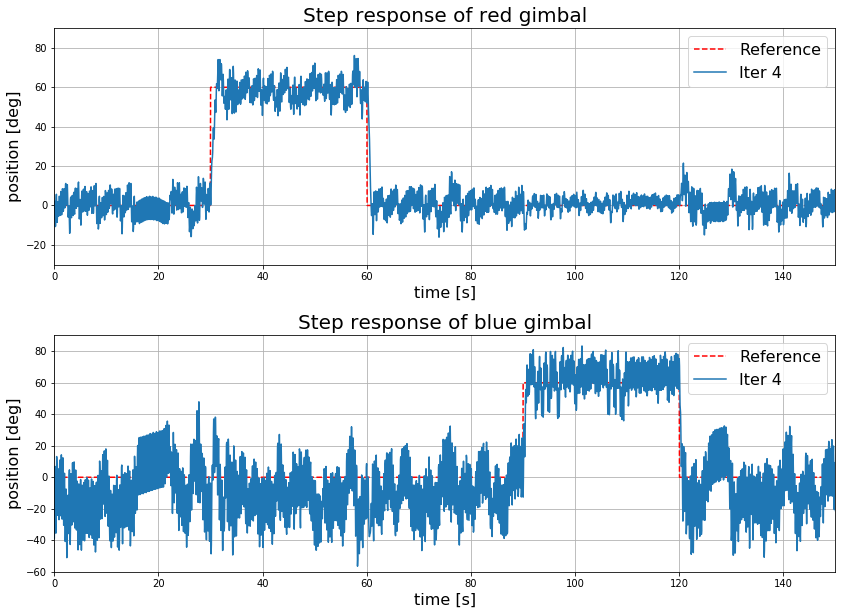

In [110]:
plot_report([read_data('NR005_m4.txt')],['Reference','Iter 4'],[-30,90,-60,90])

/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same

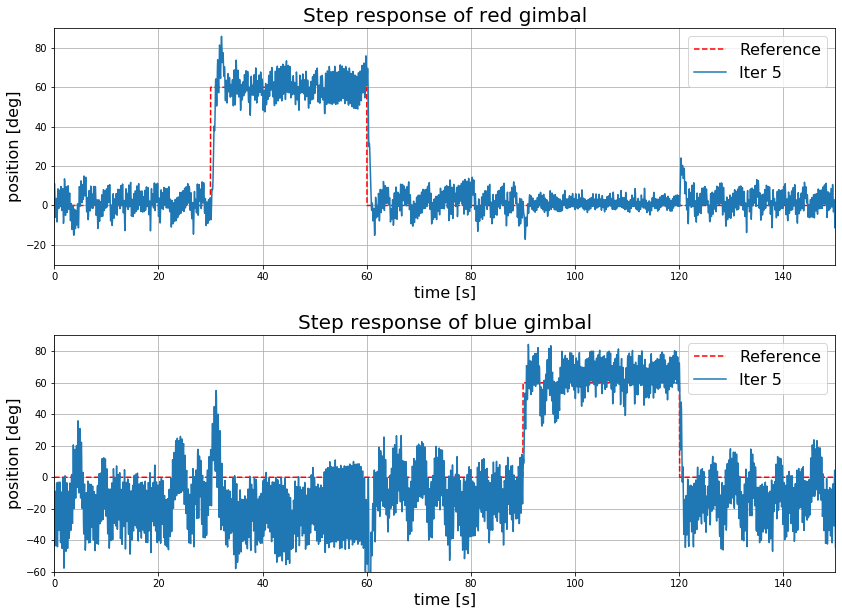

In [111]:
plot_report([read_data('NR005_m5.txt')],['Reference','Iter 5'],[-30,90,-60,90])